# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtra ct mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [ ]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [ ]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [ ]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [16]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [25]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [26]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [35]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.484332
Epoch 1, loss: 2.420238
Epoch 2, loss: 2.386164
Epoch 3, loss: 2.366295
Epoch 4, loss: 2.353694
Epoch 5, loss: 2.345128
Epoch 6, loss: 2.338965
Epoch 7, loss: 2.334332
Epoch 8, loss: 2.330725
Epoch 9, loss: 2.327839
Epoch 10, loss: 2.325479
Epoch 11, loss: 2.323511
Epoch 12, loss: 2.321846
Epoch 13, loss: 2.320418
Epoch 14, loss: 2.319181
Epoch 15, loss: 2.318097
Epoch 16, loss: 2.317142
Epoch 17, loss: 2.316295
Epoch 18, loss: 2.315535
Epoch 19, loss: 2.314853
Epoch 20, loss: 2.314235
Epoch 21, loss: 2.313672
Epoch 22, loss: 2.313159
Epoch 23, loss: 2.312688
Epoch 24, loss: 2.312255
Epoch 25, loss: 2.311856
Epoch 26, loss: 2.311486
Epoch 27, loss: 2.311142
Epoch 28, loss: 2.310822
Epoch 29, loss: 2.310523
Epoch 30, loss: 2.310244
Epoch 31, loss: 2.309983
Epoch 32, loss: 2.309736
Epoch 33, loss: 2.309505
Epoch 34, loss: 2.309287
Epoch 35, loss: 2.309080
Epoch 36, loss: 2.308885
Epoch 37, loss: 2.308700
Epoch 38, loss: 2.308524
Epoch 39, loss: 2.308358
Epoch 40, 

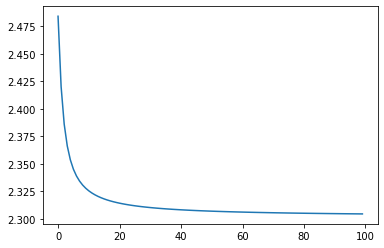

In [36]:
# let's look at the loss history!
plt.plot(loss_history)

In [40]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e2)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.125
Epoch 0, loss: 2.303230
Epoch 1, loss: 2.302916
Epoch 2, loss: 2.302815
Epoch 3, loss: 2.302773
Epoch 4, loss: 2.302743
Epoch 5, loss: 2.302723
Epoch 6, loss: 2.302709
Epoch 7, loss: 2.302697
Epoch 8, loss: 2.302686
Epoch 9, loss: 2.302679
Epoch 10, loss: 2.302674
Epoch 11, loss: 2.302670
Epoch 12, loss: 2.302667
Epoch 13, loss: 2.302663
Epoch 14, loss: 2.302661
Epoch 15, loss: 2.302658
Epoch 16, loss: 2.302654
Epoch 17, loss: 2.302651
Epoch 18, loss: 2.302650
Epoch 19, loss: 2.302648
Epoch 20, loss: 2.302646
Epoch 21, loss: 2.302645
Epoch 22, loss: 2.302645
Epoch 23, loss: 2.302643
Epoch 24, loss: 2.302642
Epoch 25, loss: 2.302641
Epoch 26, loss: 2.302640
Epoch 27, loss: 2.302639
Epoch 28, loss: 2.302638
Epoch 29, loss: 2.302637
Epoch 30, loss: 2.302636
Epoch 31, loss: 2.302636
Epoch 32, loss: 2.302636
Epoch 33, loss: 2.302635
Epoch 34, loss: 2.302635
Epoch 35, loss: 2.302635
Epoch 36, loss: 2.302635
Epoch 37, loss: 2.302634
Epoch 38, loss: 2.302634
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [44]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-2, 1e-3 * 5, 1e-3, 1e-4 * 5, 1e-4, 1e-5, 1e-5 * 5, 1e-6, 1e-6 * 5]
reg_strengths = [1e-1, 1e-2 * 5, 1e-2, 1e-3 * 5, 1e-3, 1e-4 * 5, 1e-4]

best_classifier = None
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for lr in learning_rates:
    for rg in reg_strengths:
        clf = linear_classifer.LinearSoftmaxClassifier()
        clf.fit(train_X, train_y, epochs=100, learning_rate=lr, batch_size=300, reg=rg)
        pred = clf.predict(val_X)
        if best_val_accuracy < multiclass_accuracy(pred, val_y):
            best_classifier = clf
            best_val_accuracy = multiclass_accuracy(pred, val_y)
        
print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.302045
Epoch 1, loss: 2.298231
Epoch 2, loss: 2.294788
Epoch 3, loss: 2.291784
Epoch 4, loss: 2.289096
Epoch 5, loss: 2.286672
Epoch 6, loss: 2.284500
Epoch 7, loss: 2.282562
Epoch 8, loss: 2.280828
Epoch 9, loss: 2.279244
Epoch 10, loss: 2.277811
Epoch 11, loss: 2.276537
Epoch 12, loss: 2.275364
Epoch 13, loss: 2.274271
Epoch 14, loss: 2.273280
Epoch 15, loss: 2.272373
Epoch 16, loss: 2.271549
Epoch 17, loss: 2.270793
Epoch 18, loss: 2.270094
Epoch 19, loss: 2.269452
Epoch 20, loss: 2.268850
Epoch 21, loss: 2.268280
Epoch 22, loss: 2.267762
Epoch 23, loss: 2.267285
Epoch 24, loss: 2.266835
Epoch 25, loss: 2.266417
Epoch 26, loss: 2.266023
Epoch 27, loss: 2.265657
Epoch 28, loss: 2.265314
Epoch 29, loss: 2.264990
Epoch 30, loss: 2.264684
Epoch 31, loss: 2.264399
Epoch 32, loss: 2.264133
Epoch 33, loss: 2.263875
Epoch 34, loss: 2.263628
Epoch 35, loss: 2.263398
Epoch 36, loss: 2.263180
Epoch 37, loss: 2.262971
Epoch 38, loss: 2.262775
Epoch 39, loss: 2.262583
Epoch 40, 

Epoch 30, loss: 2.228341
Epoch 31, loss: 2.227064
Epoch 32, loss: 2.225815
Epoch 33, loss: 2.224609
Epoch 34, loss: 2.223429
Epoch 35, loss: 2.222288
Epoch 36, loss: 2.221174
Epoch 37, loss: 2.220096
Epoch 38, loss: 2.219044
Epoch 39, loss: 2.218017
Epoch 40, loss: 2.217027
Epoch 41, loss: 2.216056
Epoch 42, loss: 2.215108
Epoch 43, loss: 2.214188
Epoch 44, loss: 2.213290
Epoch 45, loss: 2.212413
Epoch 46, loss: 2.211555
Epoch 47, loss: 2.210716
Epoch 48, loss: 2.209900
Epoch 49, loss: 2.209104
Epoch 50, loss: 2.208323
Epoch 51, loss: 2.207558
Epoch 52, loss: 2.206813
Epoch 53, loss: 2.206084
Epoch 54, loss: 2.205372
Epoch 55, loss: 2.204676
Epoch 56, loss: 2.203993
Epoch 57, loss: 2.203327
Epoch 58, loss: 2.202670
Epoch 59, loss: 2.202024
Epoch 60, loss: 2.201398
Epoch 61, loss: 2.200781
Epoch 62, loss: 2.200175
Epoch 63, loss: 2.199584
Epoch 64, loss: 2.199000
Epoch 65, loss: 2.198429
Epoch 66, loss: 2.197869
Epoch 67, loss: 2.197320
Epoch 68, loss: 2.196778
Epoch 69, loss: 2.196248


Epoch 60, loss: 2.194017
Epoch 61, loss: 2.193276
Epoch 62, loss: 2.192546
Epoch 63, loss: 2.191831
Epoch 64, loss: 2.191125
Epoch 65, loss: 2.190433
Epoch 66, loss: 2.189755
Epoch 67, loss: 2.189083
Epoch 68, loss: 2.188424
Epoch 69, loss: 2.187776
Epoch 70, loss: 2.187137
Epoch 71, loss: 2.186508
Epoch 72, loss: 2.185885
Epoch 73, loss: 2.185274
Epoch 74, loss: 2.184670
Epoch 75, loss: 2.184076
Epoch 76, loss: 2.183490
Epoch 77, loss: 2.182914
Epoch 78, loss: 2.182344
Epoch 79, loss: 2.181782
Epoch 80, loss: 2.181226
Epoch 81, loss: 2.180681
Epoch 82, loss: 2.180141
Epoch 83, loss: 2.179609
Epoch 84, loss: 2.179082
Epoch 85, loss: 2.178564
Epoch 86, loss: 2.178049
Epoch 87, loss: 2.177542
Epoch 88, loss: 2.177042
Epoch 89, loss: 2.176546
Epoch 90, loss: 2.176060
Epoch 91, loss: 2.175576
Epoch 92, loss: 2.175098
Epoch 93, loss: 2.174626
Epoch 94, loss: 2.174160
Epoch 95, loss: 2.173700
Epoch 96, loss: 2.173243
Epoch 97, loss: 2.172791
Epoch 98, loss: 2.172346
Epoch 99, loss: 2.171906


Epoch 89, loss: 2.217542
Epoch 90, loss: 2.217157
Epoch 91, loss: 2.216777
Epoch 92, loss: 2.216402
Epoch 93, loss: 2.216032
Epoch 94, loss: 2.215666
Epoch 95, loss: 2.215306
Epoch 96, loss: 2.214951
Epoch 97, loss: 2.214599
Epoch 98, loss: 2.214253
Epoch 99, loss: 2.213911
Epoch 0, loss: 2.300914
Epoch 1, loss: 2.298656
Epoch 2, loss: 2.296523
Epoch 3, loss: 2.294450
Epoch 4, loss: 2.292446
Epoch 5, loss: 2.290480
Epoch 6, loss: 2.288569
Epoch 7, loss: 2.286721
Epoch 8, loss: 2.284933
Epoch 9, loss: 2.283175
Epoch 10, loss: 2.281457
Epoch 11, loss: 2.279773
Epoch 12, loss: 2.278134
Epoch 13, loss: 2.276535
Epoch 14, loss: 2.274974
Epoch 15, loss: 2.273441
Epoch 16, loss: 2.271948
Epoch 17, loss: 2.270485
Epoch 18, loss: 2.269059
Epoch 19, loss: 2.267660
Epoch 20, loss: 2.266289
Epoch 21, loss: 2.264947
Epoch 22, loss: 2.263638
Epoch 23, loss: 2.262350
Epoch 24, loss: 2.261088
Epoch 25, loss: 2.259853
Epoch 26, loss: 2.258646
Epoch 27, loss: 2.257461
Epoch 28, loss: 2.256299
Epoch 29, 

Epoch 19, loss: 2.267118
Epoch 20, loss: 2.265695
Epoch 21, loss: 2.264297
Epoch 22, loss: 2.262926
Epoch 23, loss: 2.261582
Epoch 24, loss: 2.260261
Epoch 25, loss: 2.258965
Epoch 26, loss: 2.257692
Epoch 27, loss: 2.256440
Epoch 28, loss: 2.255210
Epoch 29, loss: 2.254003
Epoch 30, loss: 2.252816
Epoch 31, loss: 2.251651
Epoch 32, loss: 2.250503
Epoch 33, loss: 2.249380
Epoch 34, loss: 2.248273
Epoch 35, loss: 2.247187
Epoch 36, loss: 2.246118
Epoch 37, loss: 2.245065
Epoch 38, loss: 2.244032
Epoch 39, loss: 2.243016
Epoch 40, loss: 2.242016
Epoch 41, loss: 2.241033
Epoch 42, loss: 2.240065
Epoch 43, loss: 2.239113
Epoch 44, loss: 2.238177
Epoch 45, loss: 2.237253
Epoch 46, loss: 2.236343
Epoch 47, loss: 2.235447
Epoch 48, loss: 2.234568
Epoch 49, loss: 2.233700
Epoch 50, loss: 2.232845
Epoch 51, loss: 2.232004
Epoch 52, loss: 2.231174
Epoch 53, loss: 2.230357
Epoch 54, loss: 2.229551
Epoch 55, loss: 2.228759
Epoch 56, loss: 2.227977
Epoch 57, loss: 2.227206
Epoch 58, loss: 2.226447


Epoch 48, loss: 2.283055
Epoch 49, loss: 2.282714
Epoch 50, loss: 2.282375
Epoch 51, loss: 2.282037
Epoch 52, loss: 2.281701
Epoch 53, loss: 2.281368
Epoch 54, loss: 2.281035
Epoch 55, loss: 2.280705
Epoch 56, loss: 2.280376
Epoch 57, loss: 2.280049
Epoch 58, loss: 2.279724
Epoch 59, loss: 2.279400
Epoch 60, loss: 2.279078
Epoch 61, loss: 2.278757
Epoch 62, loss: 2.278439
Epoch 63, loss: 2.278121
Epoch 64, loss: 2.277805
Epoch 65, loss: 2.277492
Epoch 66, loss: 2.277179
Epoch 67, loss: 2.276868
Epoch 68, loss: 2.276558
Epoch 69, loss: 2.276251
Epoch 70, loss: 2.275944
Epoch 71, loss: 2.275640
Epoch 72, loss: 2.275336
Epoch 73, loss: 2.275034
Epoch 74, loss: 2.274734
Epoch 75, loss: 2.274435
Epoch 76, loss: 2.274137
Epoch 77, loss: 2.273841
Epoch 78, loss: 2.273547
Epoch 79, loss: 2.273253
Epoch 80, loss: 2.272962
Epoch 81, loss: 2.272671
Epoch 82, loss: 2.272382
Epoch 83, loss: 2.272094
Epoch 84, loss: 2.271808
Epoch 85, loss: 2.271523
Epoch 86, loss: 2.271239
Epoch 87, loss: 2.270957


Epoch 78, loss: 2.272619
Epoch 79, loss: 2.272309
Epoch 80, loss: 2.272000
Epoch 81, loss: 2.271691
Epoch 82, loss: 2.271385
Epoch 83, loss: 2.271079
Epoch 84, loss: 2.270775
Epoch 85, loss: 2.270472
Epoch 86, loss: 2.270170
Epoch 87, loss: 2.269870
Epoch 88, loss: 2.269570
Epoch 89, loss: 2.269272
Epoch 90, loss: 2.268975
Epoch 91, loss: 2.268679
Epoch 92, loss: 2.268385
Epoch 93, loss: 2.268091
Epoch 94, loss: 2.267799
Epoch 95, loss: 2.267508
Epoch 96, loss: 2.267218
Epoch 97, loss: 2.266929
Epoch 98, loss: 2.266642
Epoch 99, loss: 2.266355
Epoch 0, loss: 2.302406
Epoch 1, loss: 2.301877
Epoch 2, loss: 2.301354
Epoch 3, loss: 2.300856
Epoch 4, loss: 2.300368
Epoch 5, loss: 2.299892
Epoch 6, loss: 2.299426
Epoch 7, loss: 2.298967
Epoch 8, loss: 2.298512
Epoch 9, loss: 2.298065
Epoch 10, loss: 2.297621
Epoch 11, loss: 2.297181
Epoch 12, loss: 2.296744
Epoch 13, loss: 2.296312
Epoch 14, loss: 2.295881
Epoch 15, loss: 2.295455
Epoch 16, loss: 2.295031
Epoch 17, loss: 2.294610
Epoch 18, 

Epoch 9, loss: 2.300287
Epoch 10, loss: 2.300050
Epoch 11, loss: 2.299816
Epoch 12, loss: 2.299584
Epoch 13, loss: 2.299353
Epoch 14, loss: 2.299125
Epoch 15, loss: 2.298898
Epoch 16, loss: 2.298673
Epoch 17, loss: 2.298449
Epoch 18, loss: 2.298227
Epoch 19, loss: 2.298005
Epoch 20, loss: 2.297785
Epoch 21, loss: 2.297567
Epoch 22, loss: 2.297349
Epoch 23, loss: 2.297132
Epoch 24, loss: 2.296917
Epoch 25, loss: 2.296702
Epoch 26, loss: 2.296488
Epoch 27, loss: 2.296276
Epoch 28, loss: 2.296064
Epoch 29, loss: 2.295853
Epoch 30, loss: 2.295643
Epoch 31, loss: 2.295433
Epoch 32, loss: 2.295225
Epoch 33, loss: 2.295017
Epoch 34, loss: 2.294810
Epoch 35, loss: 2.294603
Epoch 36, loss: 2.294398
Epoch 37, loss: 2.294193
Epoch 38, loss: 2.293989
Epoch 39, loss: 2.293785
Epoch 40, loss: 2.293583
Epoch 41, loss: 2.293381
Epoch 42, loss: 2.293179
Epoch 43, loss: 2.292979
Epoch 44, loss: 2.292779
Epoch 45, loss: 2.292579
Epoch 46, loss: 2.292381
Epoch 47, loss: 2.292183
Epoch 48, loss: 2.291985
E

Epoch 38, loss: 2.293602
Epoch 39, loss: 2.293396
Epoch 40, loss: 2.293190
Epoch 41, loss: 2.292985
Epoch 42, loss: 2.292781
Epoch 43, loss: 2.292577
Epoch 44, loss: 2.292374
Epoch 45, loss: 2.292171
Epoch 46, loss: 2.291969
Epoch 47, loss: 2.291768
Epoch 48, loss: 2.291567
Epoch 49, loss: 2.291367
Epoch 50, loss: 2.291167
Epoch 51, loss: 2.290968
Epoch 52, loss: 2.290769
Epoch 53, loss: 2.290571
Epoch 54, loss: 2.290374
Epoch 55, loss: 2.290177
Epoch 56, loss: 2.289980
Epoch 57, loss: 2.289784
Epoch 58, loss: 2.289589
Epoch 59, loss: 2.289394
Epoch 60, loss: 2.289200
Epoch 61, loss: 2.289006
Epoch 62, loss: 2.288813
Epoch 63, loss: 2.288620
Epoch 64, loss: 2.288427
Epoch 65, loss: 2.288235
Epoch 66, loss: 2.288044
Epoch 67, loss: 2.287853
Epoch 68, loss: 2.287663
Epoch 69, loss: 2.287473
Epoch 70, loss: 2.287283
Epoch 71, loss: 2.287095
Epoch 72, loss: 2.286906
Epoch 73, loss: 2.286718
Epoch 74, loss: 2.286531
Epoch 75, loss: 2.286344
Epoch 76, loss: 2.286157
Epoch 77, loss: 2.285971


Epoch 68, loss: 2.300970
Epoch 69, loss: 2.300925
Epoch 70, loss: 2.300880
Epoch 71, loss: 2.300835
Epoch 72, loss: 2.300790
Epoch 73, loss: 2.300745
Epoch 74, loss: 2.300700
Epoch 75, loss: 2.300655
Epoch 76, loss: 2.300610
Epoch 77, loss: 2.300566
Epoch 78, loss: 2.300521
Epoch 79, loss: 2.300477
Epoch 80, loss: 2.300432
Epoch 81, loss: 2.300388
Epoch 82, loss: 2.300344
Epoch 83, loss: 2.300299
Epoch 84, loss: 2.300255
Epoch 85, loss: 2.300211
Epoch 86, loss: 2.300167
Epoch 87, loss: 2.300123
Epoch 88, loss: 2.300079
Epoch 89, loss: 2.300035
Epoch 90, loss: 2.299991
Epoch 91, loss: 2.299948
Epoch 92, loss: 2.299904
Epoch 93, loss: 2.299860
Epoch 94, loss: 2.299817
Epoch 95, loss: 2.299773
Epoch 96, loss: 2.299730
Epoch 97, loss: 2.299687
Epoch 98, loss: 2.299643
Epoch 99, loss: 2.299600
Epoch 0, loss: 2.302730
Epoch 1, loss: 2.302672
Epoch 2, loss: 2.302616
Epoch 3, loss: 2.302560
Epoch 4, loss: 2.302504
Epoch 5, loss: 2.302448
Epoch 6, loss: 2.302393
Epoch 7, loss: 2.302338
Epoch 8,

Epoch 97, loss: 2.297877
Epoch 98, loss: 2.297832
Epoch 99, loss: 2.297788
Epoch 0, loss: 2.302624
Epoch 1, loss: 2.302567
Epoch 2, loss: 2.302511
Epoch 3, loss: 2.302454
Epoch 4, loss: 2.302398
Epoch 5, loss: 2.302342
Epoch 6, loss: 2.302286
Epoch 7, loss: 2.302231
Epoch 8, loss: 2.302176
Epoch 9, loss: 2.302121
Epoch 10, loss: 2.302067
Epoch 11, loss: 2.302012
Epoch 12, loss: 2.301958
Epoch 13, loss: 2.301905
Epoch 14, loss: 2.301851
Epoch 15, loss: 2.301798
Epoch 16, loss: 2.301745
Epoch 17, loss: 2.301692
Epoch 18, loss: 2.301640
Epoch 19, loss: 2.301587
Epoch 20, loss: 2.301535
Epoch 21, loss: 2.301483
Epoch 22, loss: 2.301432
Epoch 23, loss: 2.301380
Epoch 24, loss: 2.301329
Epoch 25, loss: 2.301278
Epoch 26, loss: 2.301227
Epoch 27, loss: 2.301176
Epoch 28, loss: 2.301125
Epoch 29, loss: 2.301075
Epoch 30, loss: 2.301025
Epoch 31, loss: 2.300974
Epoch 32, loss: 2.300924
Epoch 33, loss: 2.300875
Epoch 34, loss: 2.300825
Epoch 35, loss: 2.300775
Epoch 36, loss: 2.300726
Epoch 37, 

Epoch 27, loss: 2.304397
Epoch 28, loss: 2.304391
Epoch 29, loss: 2.304385
Epoch 30, loss: 2.304379
Epoch 31, loss: 2.304373
Epoch 32, loss: 2.304367
Epoch 33, loss: 2.304361
Epoch 34, loss: 2.304355
Epoch 35, loss: 2.304349
Epoch 36, loss: 2.304343
Epoch 37, loss: 2.304337
Epoch 38, loss: 2.304331
Epoch 39, loss: 2.304325
Epoch 40, loss: 2.304319
Epoch 41, loss: 2.304313
Epoch 42, loss: 2.304307
Epoch 43, loss: 2.304302
Epoch 44, loss: 2.304296
Epoch 45, loss: 2.304290
Epoch 46, loss: 2.304284
Epoch 47, loss: 2.304278
Epoch 48, loss: 2.304272
Epoch 49, loss: 2.304266
Epoch 50, loss: 2.304260
Epoch 51, loss: 2.304254
Epoch 52, loss: 2.304248
Epoch 53, loss: 2.304243
Epoch 54, loss: 2.304237
Epoch 55, loss: 2.304231
Epoch 56, loss: 2.304225
Epoch 57, loss: 2.304219
Epoch 58, loss: 2.304213
Epoch 59, loss: 2.304207
Epoch 60, loss: 2.304202
Epoch 61, loss: 2.304196
Epoch 62, loss: 2.304190
Epoch 63, loss: 2.304184
Epoch 64, loss: 2.304178
Epoch 65, loss: 2.304172
Epoch 66, loss: 2.304167


Epoch 57, loss: 2.302398
Epoch 58, loss: 2.302392
Epoch 59, loss: 2.302387
Epoch 60, loss: 2.302381
Epoch 61, loss: 2.302376
Epoch 62, loss: 2.302371
Epoch 63, loss: 2.302365
Epoch 64, loss: 2.302360
Epoch 65, loss: 2.302354
Epoch 66, loss: 2.302349
Epoch 67, loss: 2.302344
Epoch 68, loss: 2.302338
Epoch 69, loss: 2.302333
Epoch 70, loss: 2.302327
Epoch 71, loss: 2.302322
Epoch 72, loss: 2.302317
Epoch 73, loss: 2.302311
Epoch 74, loss: 2.302306
Epoch 75, loss: 2.302300
Epoch 76, loss: 2.302295
Epoch 77, loss: 2.302290
Epoch 78, loss: 2.302284
Epoch 79, loss: 2.302279
Epoch 80, loss: 2.302274
Epoch 81, loss: 2.302268
Epoch 82, loss: 2.302263
Epoch 83, loss: 2.302258
Epoch 84, loss: 2.302252
Epoch 85, loss: 2.302247
Epoch 86, loss: 2.302241
Epoch 87, loss: 2.302236
Epoch 88, loss: 2.302231
Epoch 89, loss: 2.302225
Epoch 90, loss: 2.302220
Epoch 91, loss: 2.302215
Epoch 92, loss: 2.302209
Epoch 93, loss: 2.302204
Epoch 94, loss: 2.302199
Epoch 95, loss: 2.302193
Epoch 96, loss: 2.302188


Epoch 87, loss: 2.303532
Epoch 88, loss: 2.303508
Epoch 89, loss: 2.303484
Epoch 90, loss: 2.303460
Epoch 91, loss: 2.303436
Epoch 92, loss: 2.303411
Epoch 93, loss: 2.303387
Epoch 94, loss: 2.303363
Epoch 95, loss: 2.303339
Epoch 96, loss: 2.303316
Epoch 97, loss: 2.303292
Epoch 98, loss: 2.303268
Epoch 99, loss: 2.303244
Epoch 0, loss: 2.304025
Epoch 1, loss: 2.303997
Epoch 2, loss: 2.303969
Epoch 3, loss: 2.303941
Epoch 4, loss: 2.303913
Epoch 5, loss: 2.303886
Epoch 6, loss: 2.303858
Epoch 7, loss: 2.303830
Epoch 8, loss: 2.303803
Epoch 9, loss: 2.303775
Epoch 10, loss: 2.303748
Epoch 11, loss: 2.303720
Epoch 12, loss: 2.303693
Epoch 13, loss: 2.303666
Epoch 14, loss: 2.303639
Epoch 15, loss: 2.303612
Epoch 16, loss: 2.303585
Epoch 17, loss: 2.303558
Epoch 18, loss: 2.303531
Epoch 19, loss: 2.303504
Epoch 20, loss: 2.303477
Epoch 21, loss: 2.303451
Epoch 22, loss: 2.303424
Epoch 23, loss: 2.303397
Epoch 24, loss: 2.303371
Epoch 25, loss: 2.303344
Epoch 26, loss: 2.303318
Epoch 27, 

Epoch 17, loss: 2.302180
Epoch 18, loss: 2.302153
Epoch 19, loss: 2.302126
Epoch 20, loss: 2.302099
Epoch 21, loss: 2.302072
Epoch 22, loss: 2.302045
Epoch 23, loss: 2.302018
Epoch 24, loss: 2.301992
Epoch 25, loss: 2.301965
Epoch 26, loss: 2.301938
Epoch 27, loss: 2.301912
Epoch 28, loss: 2.301885
Epoch 29, loss: 2.301859
Epoch 30, loss: 2.301833
Epoch 31, loss: 2.301806
Epoch 32, loss: 2.301780
Epoch 33, loss: 2.301754
Epoch 34, loss: 2.301728
Epoch 35, loss: 2.301702
Epoch 36, loss: 2.301676
Epoch 37, loss: 2.301650
Epoch 38, loss: 2.301624
Epoch 39, loss: 2.301598
Epoch 40, loss: 2.301572
Epoch 41, loss: 2.301546
Epoch 42, loss: 2.301521
Epoch 43, loss: 2.301495
Epoch 44, loss: 2.301469
Epoch 45, loss: 2.301444
Epoch 46, loss: 2.301418
Epoch 47, loss: 2.301393
Epoch 48, loss: 2.301367
Epoch 49, loss: 2.301342
Epoch 50, loss: 2.301316
Epoch 51, loss: 2.301291
Epoch 52, loss: 2.301266
Epoch 53, loss: 2.301241
Epoch 54, loss: 2.301215
Epoch 55, loss: 2.301190
Epoch 56, loss: 2.301165


Epoch 47, loss: 2.305319
Epoch 48, loss: 2.305318
Epoch 49, loss: 2.305318
Epoch 50, loss: 2.305317
Epoch 51, loss: 2.305316
Epoch 52, loss: 2.305316
Epoch 53, loss: 2.305315
Epoch 54, loss: 2.305315
Epoch 55, loss: 2.305314
Epoch 56, loss: 2.305314
Epoch 57, loss: 2.305313
Epoch 58, loss: 2.305313
Epoch 59, loss: 2.305312
Epoch 60, loss: 2.305311
Epoch 61, loss: 2.305311
Epoch 62, loss: 2.305310
Epoch 63, loss: 2.305310
Epoch 64, loss: 2.305309
Epoch 65, loss: 2.305309
Epoch 66, loss: 2.305308
Epoch 67, loss: 2.305307
Epoch 68, loss: 2.305307
Epoch 69, loss: 2.305306
Epoch 70, loss: 2.305306
Epoch 71, loss: 2.305305
Epoch 72, loss: 2.305305
Epoch 73, loss: 2.305304
Epoch 74, loss: 2.305303
Epoch 75, loss: 2.305303
Epoch 76, loss: 2.305302
Epoch 77, loss: 2.305302
Epoch 78, loss: 2.305301
Epoch 79, loss: 2.305301
Epoch 80, loss: 2.305300
Epoch 81, loss: 2.305299
Epoch 82, loss: 2.305299
Epoch 83, loss: 2.305298
Epoch 84, loss: 2.305298
Epoch 85, loss: 2.305297
Epoch 86, loss: 2.305297


Epoch 76, loss: 2.302841
Epoch 77, loss: 2.302840
Epoch 78, loss: 2.302840
Epoch 79, loss: 2.302839
Epoch 80, loss: 2.302839
Epoch 81, loss: 2.302838
Epoch 82, loss: 2.302838
Epoch 83, loss: 2.302837
Epoch 84, loss: 2.302836
Epoch 85, loss: 2.302836
Epoch 86, loss: 2.302835
Epoch 87, loss: 2.302835
Epoch 88, loss: 2.302834
Epoch 89, loss: 2.302834
Epoch 90, loss: 2.302833
Epoch 91, loss: 2.302833
Epoch 92, loss: 2.302832
Epoch 93, loss: 2.302831
Epoch 94, loss: 2.302831
Epoch 95, loss: 2.302830
Epoch 96, loss: 2.302830
Epoch 97, loss: 2.302829
Epoch 98, loss: 2.302829
Epoch 99, loss: 2.302828
Epoch 0, loss: 2.302288
Epoch 1, loss: 2.302288
Epoch 2, loss: 2.302287
Epoch 3, loss: 2.302287
Epoch 4, loss: 2.302286
Epoch 5, loss: 2.302286
Epoch 6, loss: 2.302285
Epoch 7, loss: 2.302285
Epoch 8, loss: 2.302284
Epoch 9, loss: 2.302284
Epoch 10, loss: 2.302283
Epoch 11, loss: 2.302283
Epoch 12, loss: 2.302282
Epoch 13, loss: 2.302282
Epoch 14, loss: 2.302281
Epoch 15, loss: 2.302281
Epoch 16, 

Epoch 7, loss: 2.305614
Epoch 8, loss: 2.305611
Epoch 9, loss: 2.305608
Epoch 10, loss: 2.305605
Epoch 11, loss: 2.305602
Epoch 12, loss: 2.305600
Epoch 13, loss: 2.305597
Epoch 14, loss: 2.305594
Epoch 15, loss: 2.305591
Epoch 16, loss: 2.305588
Epoch 17, loss: 2.305585
Epoch 18, loss: 2.305583
Epoch 19, loss: 2.305580
Epoch 20, loss: 2.305577
Epoch 21, loss: 2.305574
Epoch 22, loss: 2.305571
Epoch 23, loss: 2.305568
Epoch 24, loss: 2.305566
Epoch 25, loss: 2.305563
Epoch 26, loss: 2.305560
Epoch 27, loss: 2.305557
Epoch 28, loss: 2.305554
Epoch 29, loss: 2.305551
Epoch 30, loss: 2.305549
Epoch 31, loss: 2.305546
Epoch 32, loss: 2.305543
Epoch 33, loss: 2.305540
Epoch 34, loss: 2.305537
Epoch 35, loss: 2.305535
Epoch 36, loss: 2.305532
Epoch 37, loss: 2.305529
Epoch 38, loss: 2.305526
Epoch 39, loss: 2.305523
Epoch 40, loss: 2.305521
Epoch 41, loss: 2.305518
Epoch 42, loss: 2.305515
Epoch 43, loss: 2.305512
Epoch 44, loss: 2.305509
Epoch 45, loss: 2.305506
Epoch 46, loss: 2.305504
Epo

Epoch 38, loss: 2.302480
Epoch 39, loss: 2.302478
Epoch 40, loss: 2.302475
Epoch 41, loss: 2.302472
Epoch 42, loss: 2.302469
Epoch 43, loss: 2.302466
Epoch 44, loss: 2.302463
Epoch 45, loss: 2.302460
Epoch 46, loss: 2.302458
Epoch 47, loss: 2.302455
Epoch 48, loss: 2.302452
Epoch 49, loss: 2.302449
Epoch 50, loss: 2.302446
Epoch 51, loss: 2.302443
Epoch 52, loss: 2.302441
Epoch 53, loss: 2.302438
Epoch 54, loss: 2.302435
Epoch 55, loss: 2.302432
Epoch 56, loss: 2.302429
Epoch 57, loss: 2.302426
Epoch 58, loss: 2.302423
Epoch 59, loss: 2.302421
Epoch 60, loss: 2.302418
Epoch 61, loss: 2.302415
Epoch 62, loss: 2.302412
Epoch 63, loss: 2.302409
Epoch 64, loss: 2.302406
Epoch 65, loss: 2.302404
Epoch 66, loss: 2.302401
Epoch 67, loss: 2.302398
Epoch 68, loss: 2.302395
Epoch 69, loss: 2.302392
Epoch 70, loss: 2.302390
Epoch 71, loss: 2.302387
Epoch 72, loss: 2.302384
Epoch 73, loss: 2.302381
Epoch 74, loss: 2.302378
Epoch 75, loss: 2.302375
Epoch 76, loss: 2.302373
Epoch 77, loss: 2.302370


Epoch 68, loss: 2.302222
Epoch 69, loss: 2.302219
Epoch 70, loss: 2.302216
Epoch 71, loss: 2.302214
Epoch 72, loss: 2.302211
Epoch 73, loss: 2.302208
Epoch 74, loss: 2.302205
Epoch 75, loss: 2.302202
Epoch 76, loss: 2.302200
Epoch 77, loss: 2.302197
Epoch 78, loss: 2.302194
Epoch 79, loss: 2.302191
Epoch 80, loss: 2.302189
Epoch 81, loss: 2.302186
Epoch 82, loss: 2.302183
Epoch 83, loss: 2.302180
Epoch 84, loss: 2.302178
Epoch 85, loss: 2.302175
Epoch 86, loss: 2.302172
Epoch 87, loss: 2.302169
Epoch 88, loss: 2.302167
Epoch 89, loss: 2.302164
Epoch 90, loss: 2.302161
Epoch 91, loss: 2.302158
Epoch 92, loss: 2.302155
Epoch 93, loss: 2.302153
Epoch 94, loss: 2.302150
Epoch 95, loss: 2.302147
Epoch 96, loss: 2.302144
Epoch 97, loss: 2.302142
Epoch 98, loss: 2.302139
Epoch 99, loss: 2.302136
best validation accuracy achieved: 0.241000


# Какой же точности мы добились на тестовых данных?

In [45]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.201000
